# Imports

In [10]:
import sys
sys.path.append("../Face_detection")
sys.path.append("../")

import cv2
import face_detection
import glob
import importlib
import random
import os
import zipfile

importlib.reload(face_detection)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from face_detection import predict_detected_faces
from data_augmenation_pipeline import DataAugmentationPipeline
from PIL import Image
from keras import initializers, regularizers, Sequential
from keras.applications import EfficientNetB0, InceptionV3, MobileNet, MobileNetV2, ResNet50, VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import (
    AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout,
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D,
    SpatialDropout2D
)
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [11]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [12]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# Data Augmentation

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3.509404210409718,
    shear_range=0.06420358224658541,
    zoom_range=0.09459576165592101,
    width_shift_range=0.0381462510165483,
    height_shift_range=0.05870979662454212,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Plotting a batch of training data

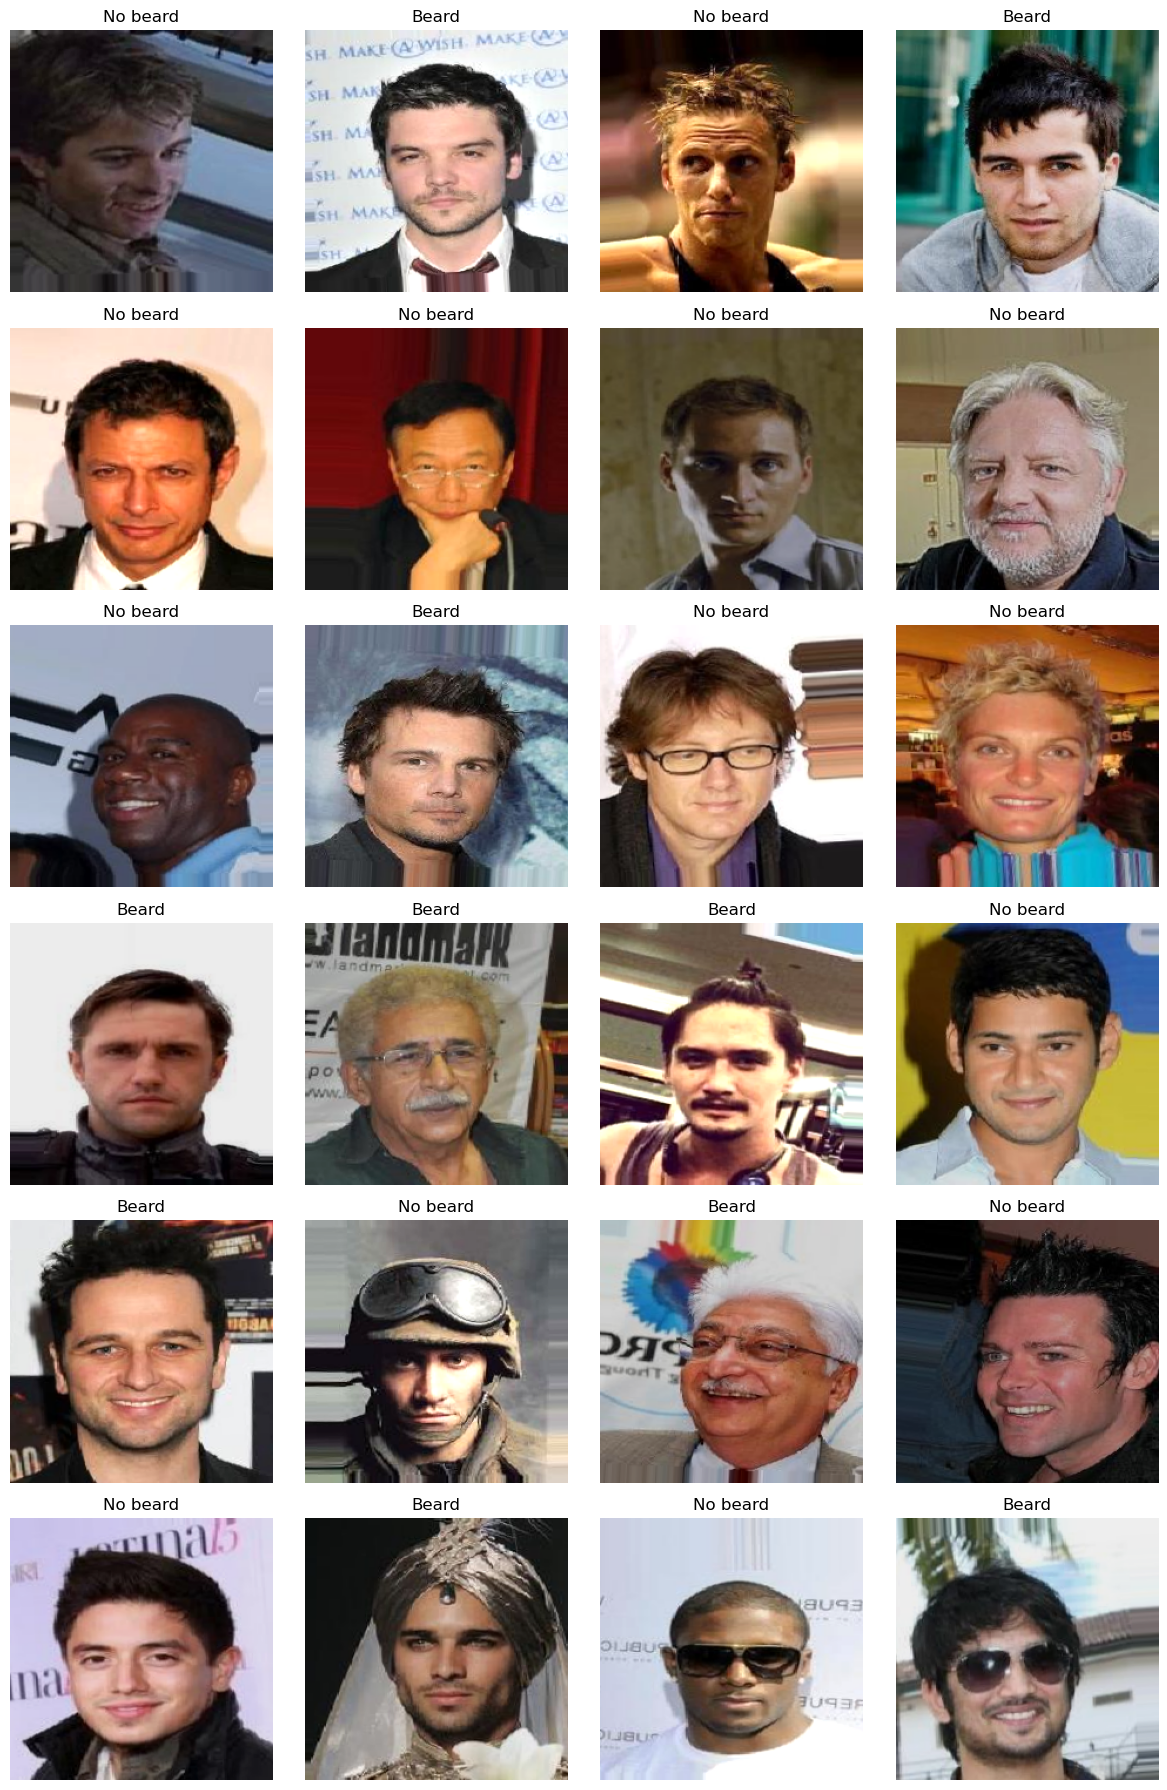

In [15]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    label = "Beard" if y_batch[i] == 0 else "No beard"
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [16]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 51200)             0         
                                                                 
 dense_24 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 74233633 (283.18 MB)
Trainable params: 59604161 (227.37 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40
100/100 [==============================] - 34s 264ms/step - loss: 2.3780 - acc: 0.6961 - val_loss: 0.5580 - val_acc: 0.8000
Epoch 2/40
100/100 [==============================] - 25s 251ms/step - loss: 0.4364 - acc: 0.7958 - val_loss: 0.3919 - val_acc: 0.8400
Epoch 3/40
100/100 [==============================] - 25s 252ms/step - loss: 0.4103 - acc: 0.8208 - val_loss: 0.3745 - val_acc: 0.8350
Epoch 4/40
100/100 [==============================] - 25s 253ms/step - loss: 0.4048 - acc: 0.8138 - val_loss: 0.3546 - val_acc: 0.8450
Epoch 5/40
100/100 [==============================] - 25s 247ms/step - loss: 0.3763 - acc: 0.8303 - val_loss: 0.3573 - val_acc: 0.8587
Epoch 6/40
100/100 [==============================] - 25s 249ms/step - loss: 0.3561 - acc: 0.8482 - val_loss: 0.3738 - val_acc: 0.8138
Epoch 7/40
100/100 [==============================] - 25s 247ms/step - loss: 0.3548 - acc: 0.8433 - val_loss: 0.3587 - val_acc: 0.8525
Epoch 8/40
100/100 [==============================] - 2

# Data Augmenation Pipeline call

In [8]:
def generate_random_config():
    return {
        'rotation': random.uniform(0, 10),             
        'zoom': random.uniform(0, 0.25),             
        'width_shift': random.uniform(0, 0.1),
        'height_shift': random.uniform(0, 0.1),
        'shear': random.uniform(0, 0.1),           
        'hflip': True,                                
        'brightness': random.choice([[0.7, 1.3], [0.8, 1.2], None]) 
}

results = []

for i in range(10):
    config = generate_random_config()
    print(f"\n[INFO] Running config {i+1}: {config}")
    pipeline = DataAugmentationPipeline(config=config, batch_size=batch_size, target_size=target_size, class_mode='binary')
    
    train_gen = pipeline.get_train_generator()
    valid_gen = pipeline.get_valid_generator()
    test_gen = pipeline.get_test_generator()
    
    # Build the model for each iteration new
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])

    history = model.fit(
        train_gen,
        batch_size=batch_size,
        epochs=40,
        validation_data=valid_gen,
        steps_per_epoch=100,
        callbacks=[early_stopping]
    )
    
    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    results.append({
        'config': config,
        'val_acc': max(history.history['val_acc']),
        'test_acc': test_acc,
        'history': history.history
    })

# Sorted after best test accuracy
results = sorted(results, key=lambda x: x['test_acc'], reverse=True)

for r in results:
    print(f"\nConfig: {r['config']}\n-> Val Acc: {r['val_acc']:.4f} | Test Acc: {r['test_acc']:.4f}")


[INFO] Running config 1: {'rotation': 1.6179612266441235, 'zoom': 0.18642075167245625, 'width_shift': 0.05660200896731972, 'height_shift': 0.06782513280418345, 'shear': 0.0740308137360534, 'hflip': True, 'brightness': None}
Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/40
100/100 [==============================] - 30s 235ms/step - loss: 2.7288 - acc: 0.6558 - val_loss: 1.7282 - val_acc: 0.6513
Epoch 2/40
100/100 [==============================] - 22s 218ms/step - loss: 0.4784 - acc: 0.7876 - val_loss: 0.4228 - val_acc: 0.8400
Epoch 3/40
100/100 [==============================] - 21s 214ms/step - loss: 0.4365 - acc: 0.8089 - val_loss: 0.4271 - val_acc: 0.8225
Epoch 4/40
100/100 [==============================] - 22s 215ms/step - loss: 0.4039 - acc: 0.8148 - val_loss: 0.3870 - val_acc: 0.8475
Epoch 5/40
100/100 [==============================] - 22s 215ms/step - loss: 0.3788 - acc: 0.8294 - val_loss: 0

# Plot the results of the training with a Data Augmentation Pipeline 

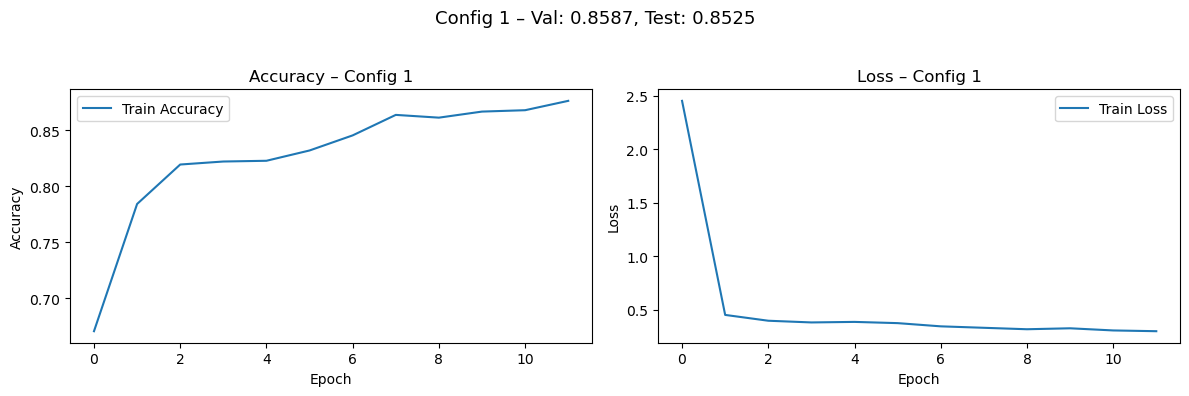

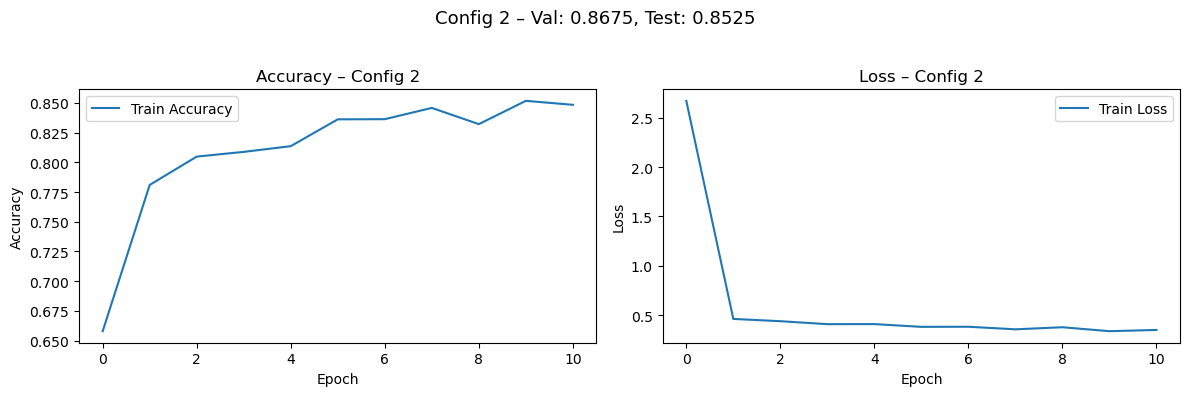

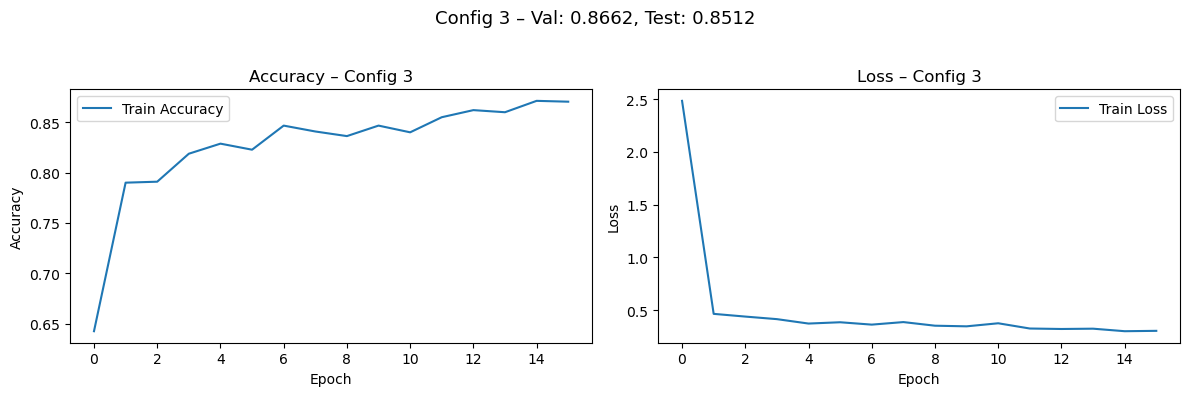

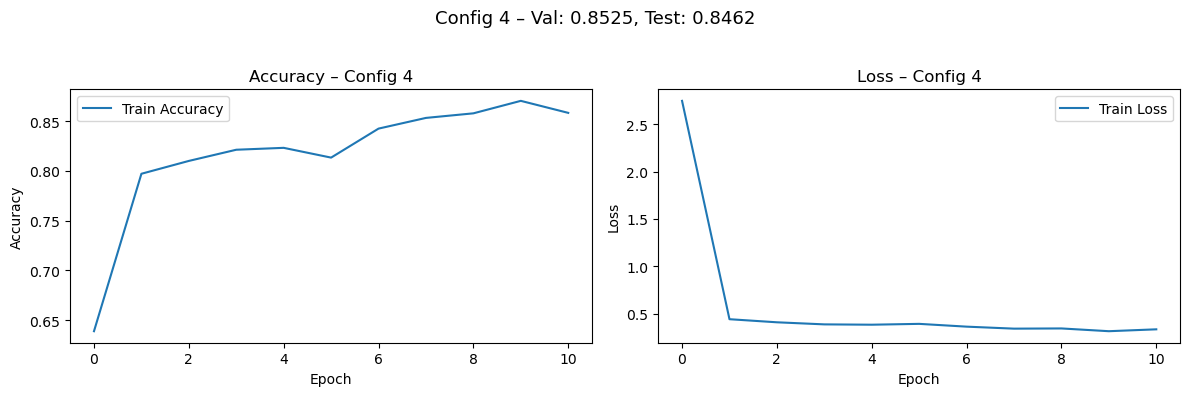

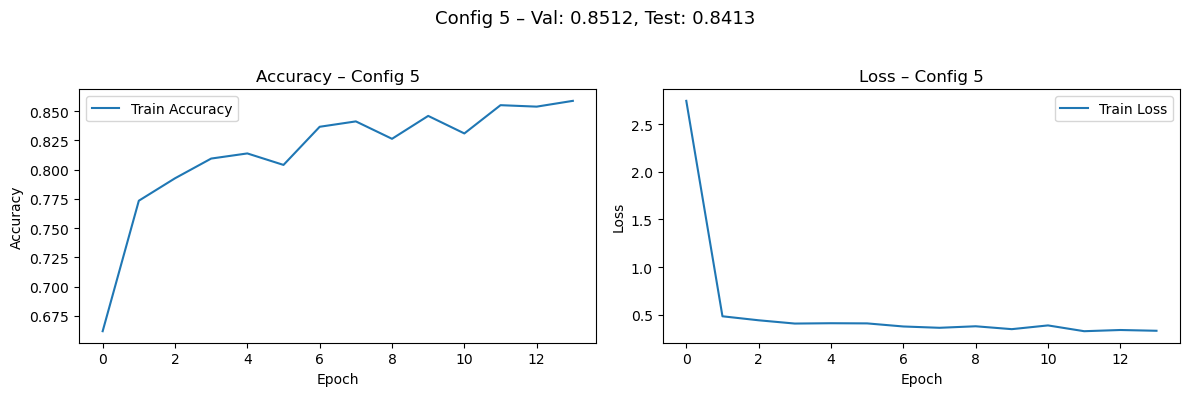

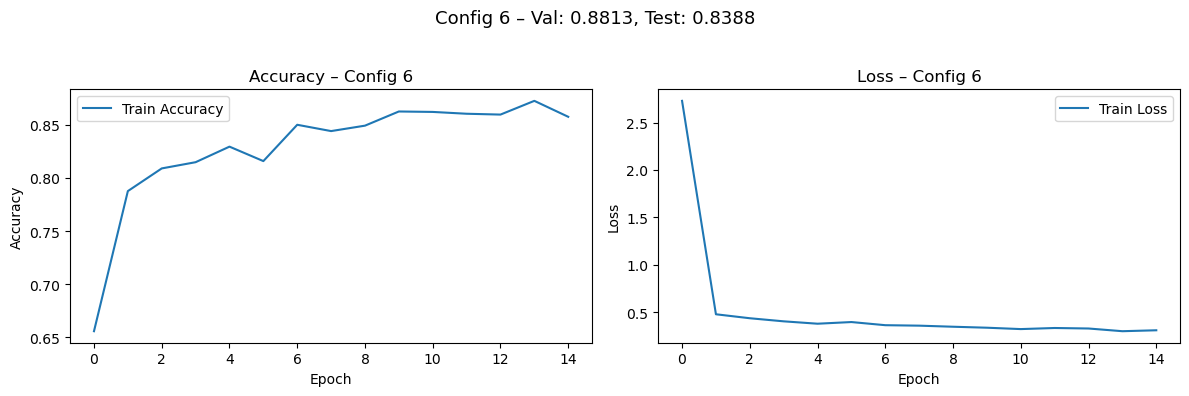

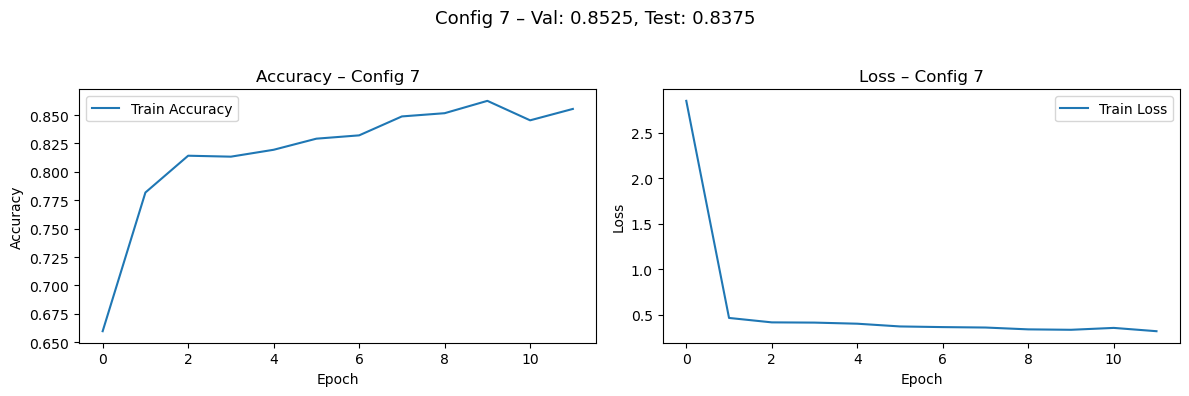

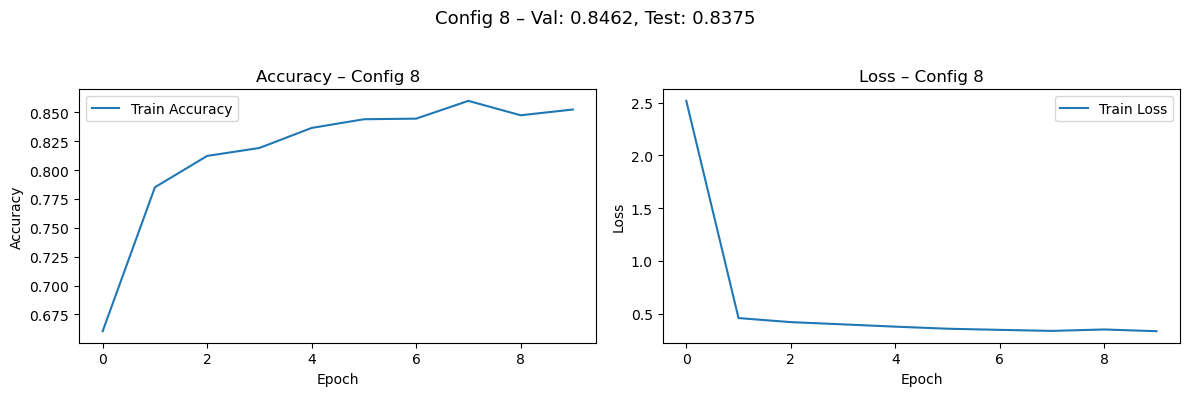

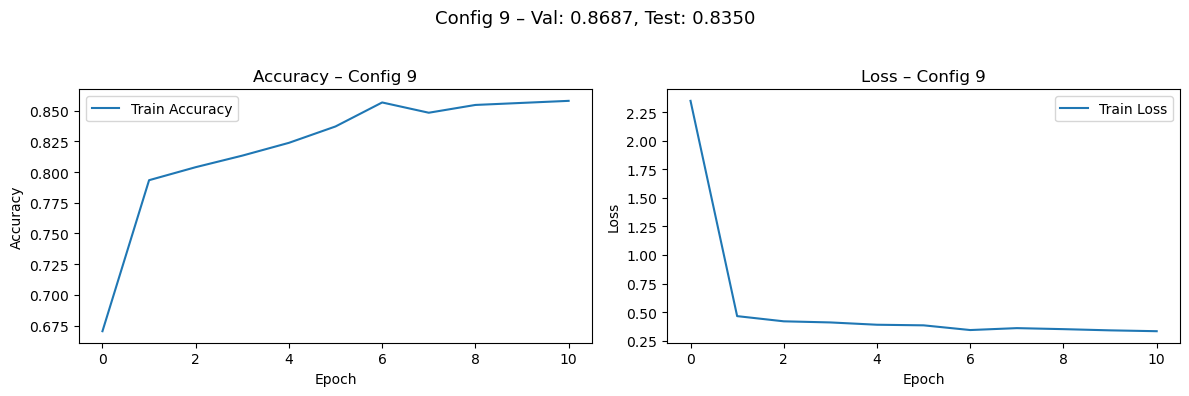

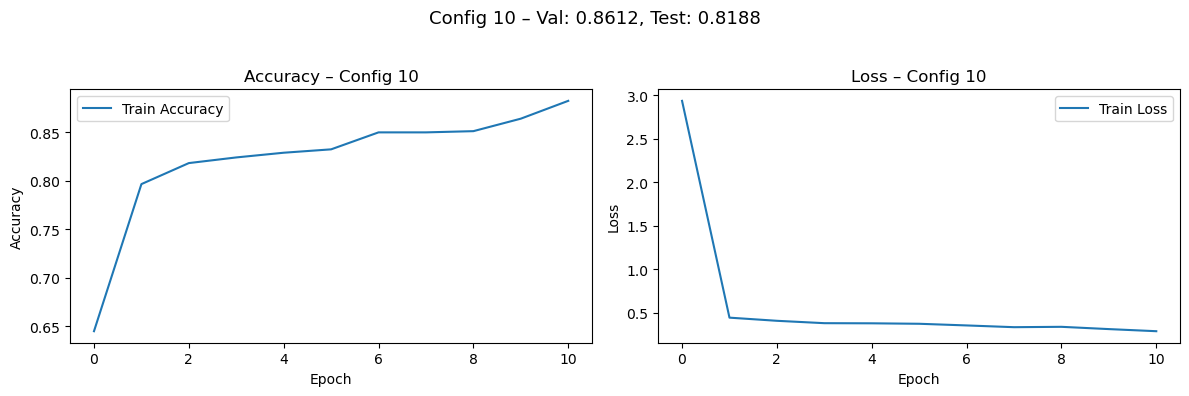

In [9]:
for i, r in enumerate(results):
    history = r.get('history', None)
    
    if history is None:
        print(f"[WARNUNG] No training history for config {i+1} available – please log the history.")
        continue

    config = r['config']
    val_acc = r['val_acc']
    test_acc = r['test_acc']

    acc_key = 'accuracy' if 'accuracy' in history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history[acc_key], label='Train Accuracy')
    plt.title(f'Accuracy – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Loss – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f'Config {i+1} – Val: {val_acc:.4f}, Test: {test_acc:.4f}', fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the results of the training

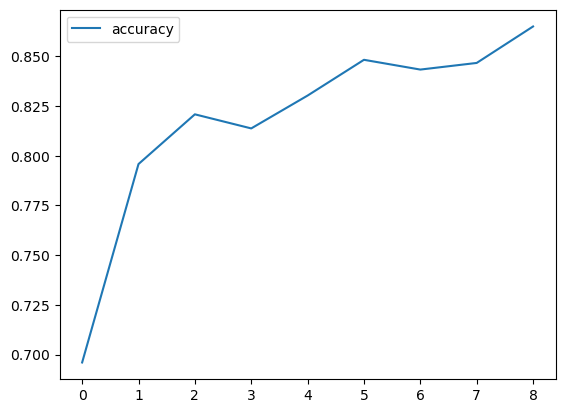

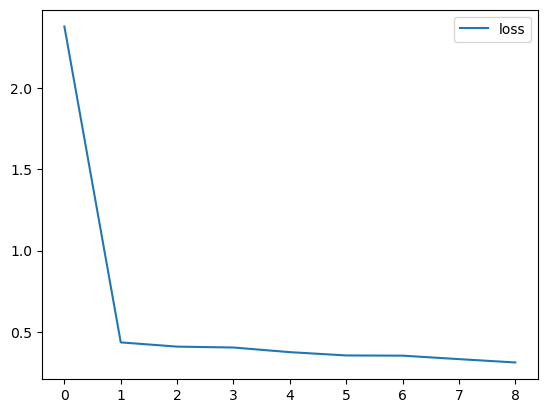

In [18]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


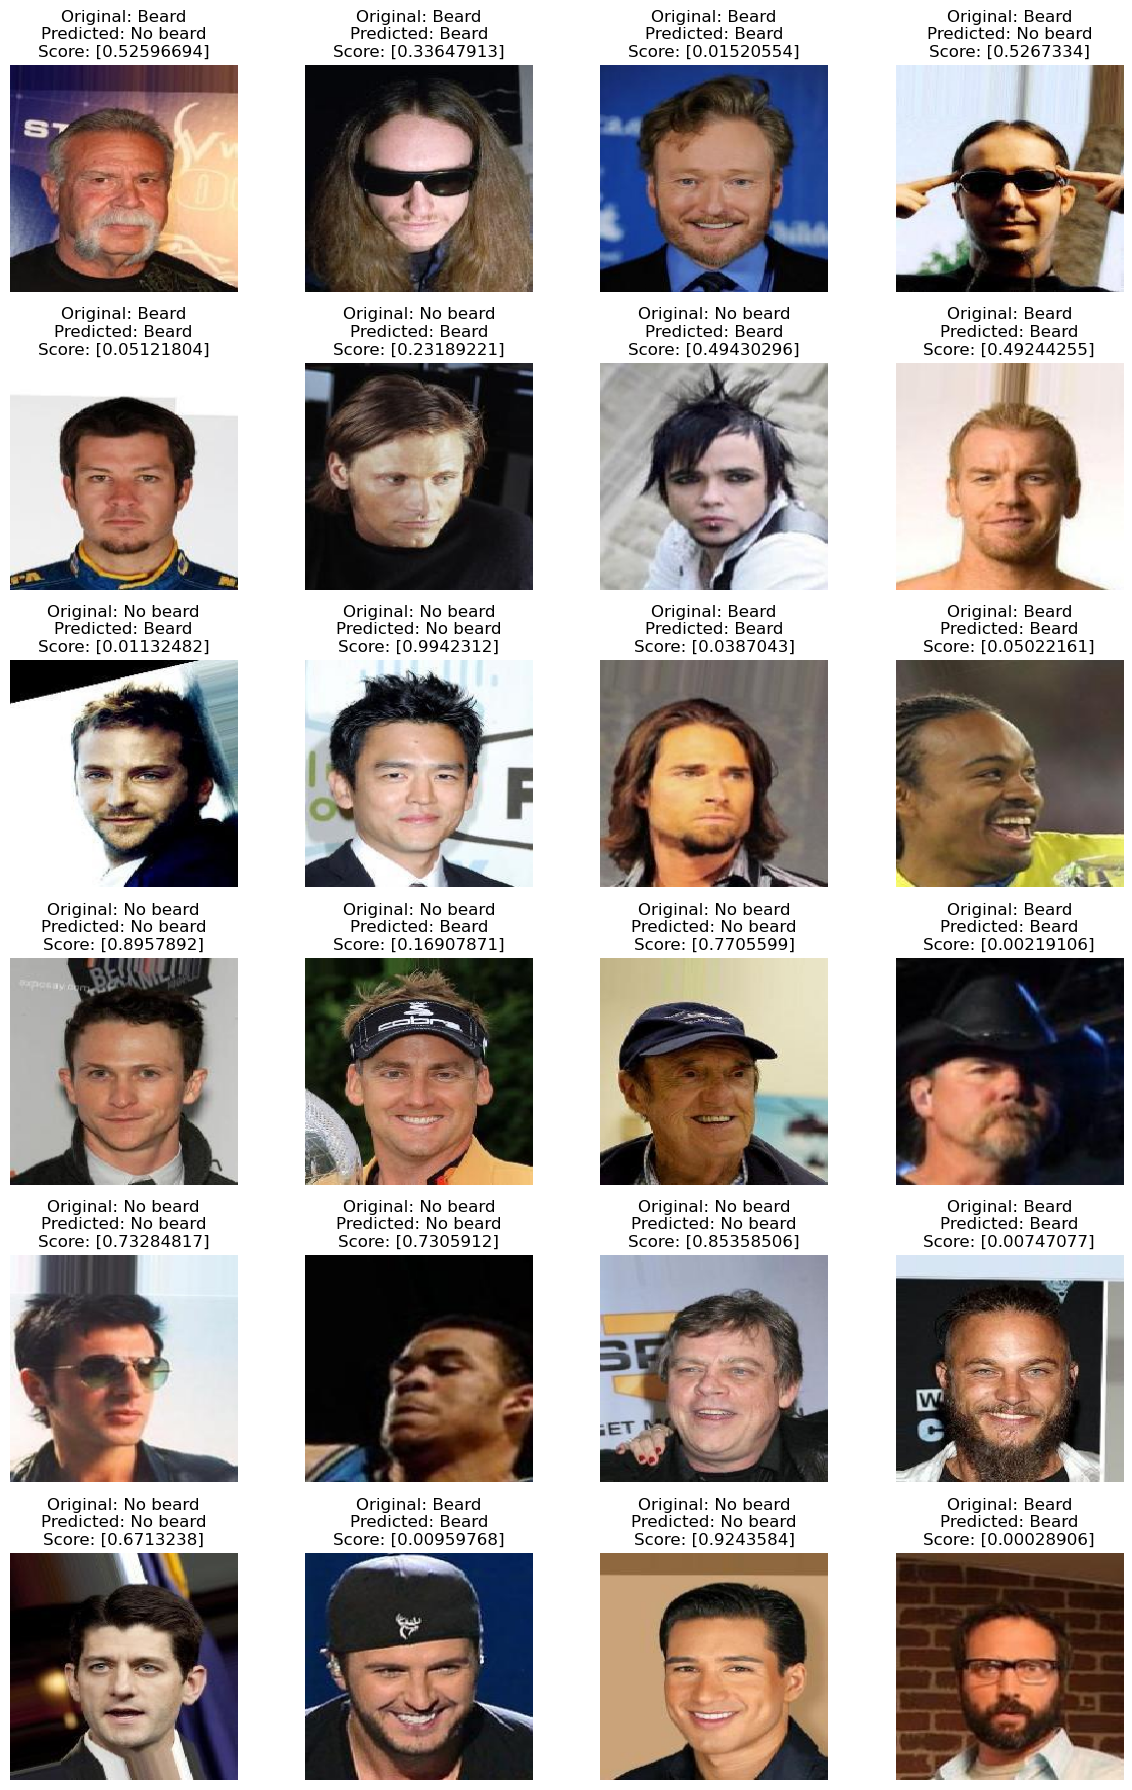

In [19]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

# print(f"Predictions {predictions}")
predicted_labels = (predictions > 0.5).astype(int).flatten()
# print(predicted_labels)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

class_names = ["Beard", "No beard"]

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    true_label = class_names[int(y_batch[i])]
    predicted_label = class_names[predicted_labels[i]]
    
    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {predictions[i]}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 1s 1s/step


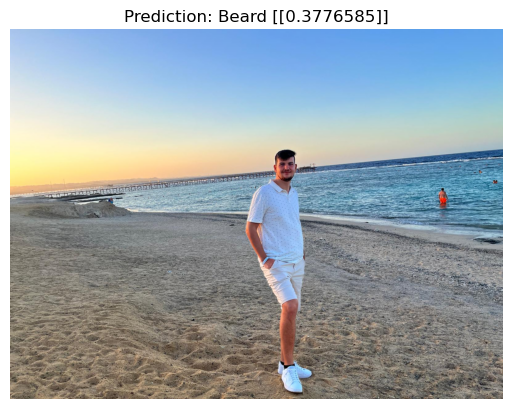

1/1 [==============================] - 0s 36ms/step


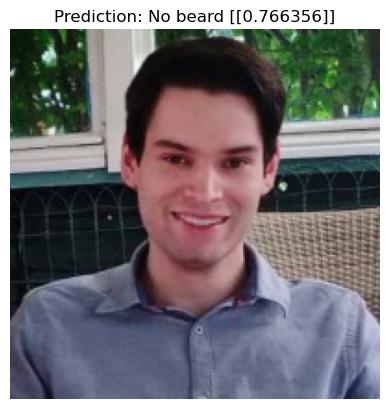

1/1 [==============================] - 0s 38ms/step


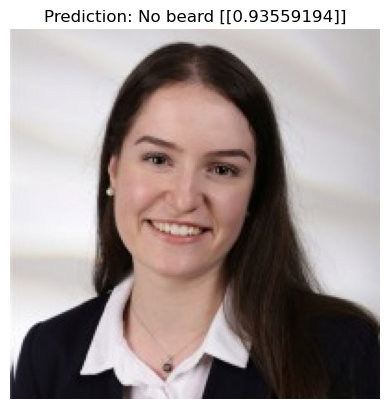

1/1 [==============================] - 0s 33ms/step


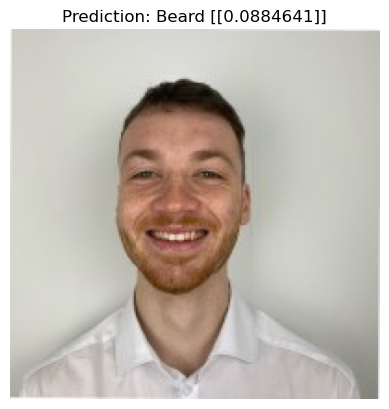

In [20]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

class_names = ["Beard", "No beard"]

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
    img_array = edit_image(image)
    
    prediction = model.predict(img_array)
    predicted_labels = (prediction > 0.5).astype(int).flatten()
    predicted_label = class_names[predicted_labels[0]]

    plt.imshow(load_img(image))
    plt.title(f"Prediction: {predicted_label} {prediction}")
    plt.axis("off")
    plt.show()

# Evaluate the model ans save it to a file

In [21]:
model.evaluate(test_gen)
model.save("../Models/With_DA_Pipeline/Beard_classification")

34/34 [==============================] - 1s 38ms/step - loss: 0.3777 - acc: 0.8238
INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Beard_classification/assets


INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Beard_classification/assets


# Test the model on detected and extracted faces

In [ ]:
model_with_pipeline = load_model("../Models/With_DA_Pipeline/Beard_classification")
model_without_pipeline = load_model("../Models/Without_DA_Pipeline/Beard_classification")

print("Predicting with the model which was trained with the pipeline:")
predict_detected_faces(model=model_with_pipeline, class_names=["Beard", "No Beard"], padding=0.3)

print("Predicting with the model which was trained without the pipeline:")
predict_detected_faces(model=model_without_pipeline, class_names=["Beard", "No Beard"], padding=0.3)